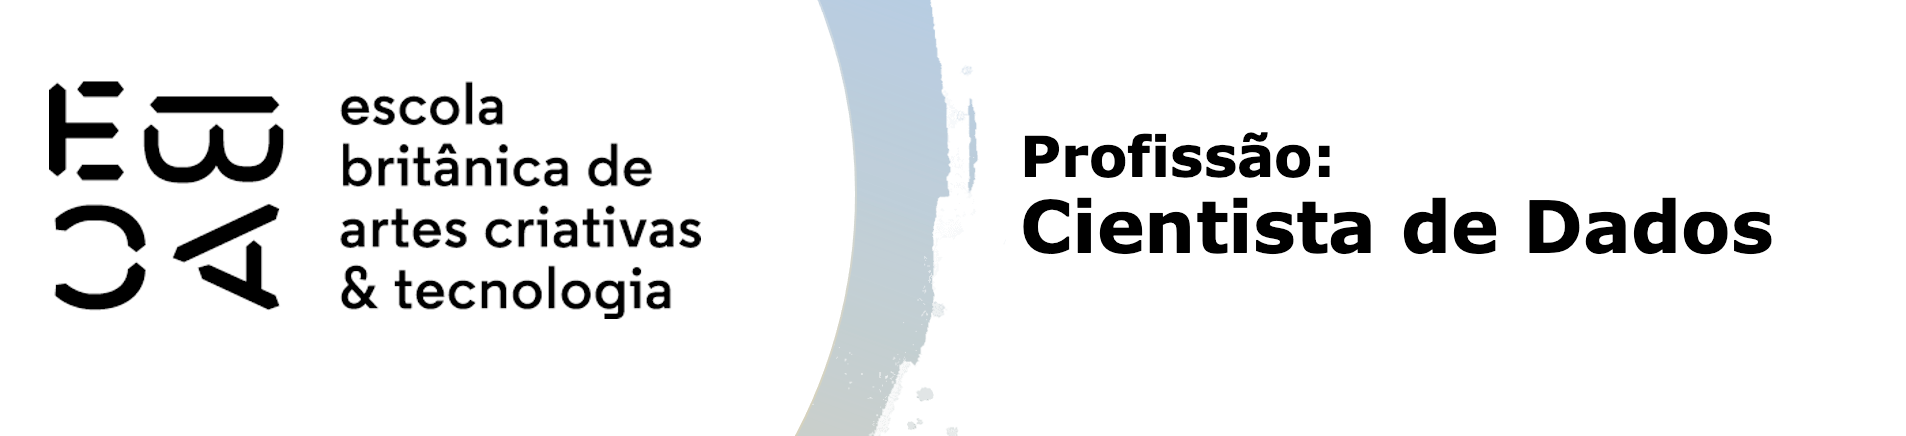

# Regressão III - Tarefa

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import patsy
import warnings

import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.interpolate import interp1d


In [2]:
df = pd.read_csv('previsao_de_renda_II.csv', index_col=0)
df.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
data_ref,,,,,,,,,,,,,
2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


## Avalie valores missing e substitua pela média

Neste exercício não vamos nos preocupar com valores *missing*. Substitua-os pela média.

In [3]:
df['tempo_emprego'] = df['tempo_emprego'].fillna(df['tempo_emprego'].median()) 

In [4]:
df.isna().sum()

index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
dtype: int64

### Base de testes

Separe os três últimos meses como base *holdout* (base de teste).

In [5]:
df_train = df[:'2015-12-01']
df_test = df['2016-01-01':]

### Primeiro modelo
 Não use *index* e não use a data. Avalie o modelo com o $R^2-ajustado$

In [6]:
X1 = patsy.dmatrices('''np.log(renda) ~ C(sexo) 
                    + C(posse_de_veiculo) 
                    + C(posse_de_imovel)
                    + qtd_filhos 
                    + C(tipo_renda) 
                    + C(educacao, Treatment(2)) 
                    + C(estado_civil) 
                    + C(tipo_residencia, Treatment(1)) 
                    + idade
                    + tempo_emprego
                    + qt_pessoas_residencia 
                    + 1''', df_train)

In [7]:
res = smf.ols(X1, data=df_train).fit_regularized(method = 'elastic_net' 
                         , refit = True
                         , L1_wt = 1
                         , alpha = 0.05)

resumo = res.summary()
resumo.tables[0]

Dep. Variable:,np.log(renda),R-squared:,0.430
Model:,OLS,Adj. R-squared:,0.430
Method:,Least Squares,F-statistic:,9.052e+04
Date:,"Thu, 01 Sep 2022",Prob (F-statistic):,0.00
Time:,16:01:08,Log-Likelihood:,-8.0161e+05
No. Observations:,600000,AIC:,1.603e+06
Df Residuals:,599995,BIC:,1.603e+06
Df Model:,5,,
Covariance Type:,nonrobust,,


In [8]:
tabela = pd.read_html(resumo.tables[1].as_html(), header=0, index_col=0)[0]
tabela.style.format(decimal=',', precision=4)\
    .highlight_between(
        left=.05
        , axis=1
        , props='color:red'
        , subset='P>|t|'
    ).set_properties(**{'background-color': '#ffffb3'}, subset=['[0.025', '0.975]'])

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,"8,2031","0,0070","1197,8390","0,0000","8,1900","8,2170"
C(sexo)[T.M],"0,0000","0,0000",nan,nan,"0,0000","0,0000"
C(posse_de_veiculo)[T.S],"0,0000","0,0000",nan,nan,"0,0000","0,0000"
C(posse_de_imovel)[T.S],"0,1809","0,0030","70,7870","0,0000","0,1760","0,1860"
C(tipo_renda)[T.Bolsista],"0,0000","0,0000",nan,nan,"0,0000","0,0000"
C(tipo_renda)[T.Empresário],"0,0000","0,0000",nan,nan,"0,0000","0,0000"
C(tipo_renda)[T.Pensionista],"0,0000","0,0000",nan,nan,"0,0000","0,0000"
C(tipo_renda)[T.Servidor público],"0,0000","0,0000",nan,nan,"0,0000","0,0000"
"C(educacao, Treatment(2))[T.Fundamental]","0,0000","0,0000",nan,nan,"0,0000","0,0000"
"C(educacao, Treatment(2))[T.Médio]","0,0000","0,0000",nan,nan,"0,0000","0,0000"


### Análise de perfil

Categorize a variável ```tempo_emprego``` em 20 quantis (cada categoria deve ter aproximadamente a mesma quantidade de observações) e faça uma tabela de perfil (armazene como dataframe) para esta categorização:

- Cada linha é uma categoria
- Uma coluna para a quantidade de observações de cada categoria
- Uma coluna para a média do log-renda para cada categoria
- Uma coluna para a média do tempo de emprego para cada categoria

Faça um gráfico da média do tempo de emprego pela média do log-renda. Insira uma célula de texto e comente se te parece que alguma das transformações vistas no módulo deve fornecer bons resultados.

In [9]:
df_train['tempo_emprego_cat'], quebras = pd.qcut(df_train.tempo_emprego, 20, duplicates='drop', retbins=True)

warnings.filterwarnings('ignore')

C:\Users\Fernanda\AppData\Local\Temp\ipykernel_13612\1490223939.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['tempo_emprego_cat'], quebras = pd.qcut(df_train.tempo_emprego, 20, duplicates='drop', retbins=True)


In [10]:
quebras

array([ 0.11780822,  0.81643836,  1.45753425,  2.09589041,  2.91232877,
        3.63561644,  4.29863014,  4.93424658,  5.75890411,  6.04657534,
        6.35890411,  7.12054795,  8.10684932,  9.08219178, 10.43561644,
       12.46575342, 15.21369863, 20.21643836, 42.90684932])

In [11]:
df_train['tempo_emprego_cat'] = pd.cut(df_train.tempo_emprego, bins = quebras, duplicates='drop')

In [12]:
tab_perfil = pd.DataFrame()
tab_perfil['qtd_obs'] = df_train['tempo_emprego_cat'].value_counts()
df_train['log_renda']=np.log(df_train['renda'])
tab_perfil['log_renda_med'] = df_train.groupby('tempo_emprego_cat')['log_renda'].mean()
tab_perfil['tempo_emprego_med'] = df_train.groupby('tempo_emprego_cat')['tempo_emprego'].mean()
tab_perfil.sort_index(axis = 0, inplace = True)
tab_perfil.reset_index(inplace=True)
tab_perfil.rename(columns={'index':'tempo_emprego_cat'}, inplace=True)
tab_perfil

,tempo_emprego_cat,qtd_obs,log_renda_med,tempo_emprego_med
0,"(0.118, 0.816]",30207,8.365576,0.515397
1,"(0.816, 1.458]",30031,8.454323,1.125014
2,"(1.458, 2.096]",29736,8.569544,1.781261
3,"(2.096, 2.912]",30013,8.624148,2.510920
4,"(2.912, 3.636]",30408,8.755365,3.301180
5,"(3.636, 4.299]",29625,8.855078,3.987156
6,"(4.299, 4.934]",30109,8.903273,4.610421
7,"(4.934, 5.759]",29991,9.049495,5.367829
8,"(5.759, 6.047]",110726,9.040393,6.034873
9,"(6.047, 6.359]",9178,9.102869,6.200063


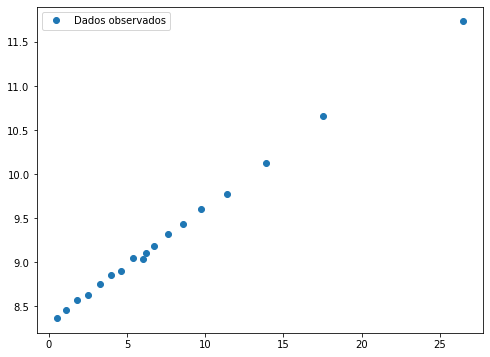

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(tab_perfil.tempo_emprego_med, tab_perfil.log_renda_med, "o", label="Dados observados", alpha=1)
ax.legend()

### Linearização

Experimente pelo menos duas técnicas de linearização vistas ao longo do módulo para melhorar o ajuste da variável ```tempo_emprego```. Compare o $R^2-ajustado$ e avalie se alguma delas apresentou resultados relevantes com relação ao primeiro modelo.


In [14]:
nsample2 = 50000
sig = 0.5
x2 = np.linspace(0, 20, nsample2)
X2 = np.column_stack((x2, np.sin(x2), (x2 - 5) ** 2, np.ones(nsample2)))
beta = [0.5, 0.5, -0.02, 5.0]

y_true2 = np.dot(X2, beta)
y2 = y_true2 + sig * np.random.normal(size=nsample2)

df = pd.DataFrame(X2, columns = ['X1', 'X2', 'X3', 'Int'])
df['y'] = y2
df['y_true'] = y_true2
df.head()

,X1,X2,X3,Int,y,y_true
0,0.0000,0.0000,25.000000,1.0,3.694787,4.50000
1,0.0004,0.0004,24.996000,1.0,5.108733,4.50048
2,0.0008,0.0008,24.992000,1.0,4.409842,4.50096
3,0.0012,0.0012,24.988001,1.0,4.346403,4.50144
4,0.0016,0.0016,24.984002,1.0,4.553747,4.50192


In [15]:
def esp_vs_obs(data=df):
    pred_ols = res.get_prediction()
    iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    iv_u = pred_ols.summary_frame()["obs_ci_upper"]
    
    m_l = pred_ols.summary_frame()["mean_ci_lower"]
    m_u = pred_ols.summary_frame()["mean_ci_upper"]

    fig, ax = plt.subplots(figsize=(8, 6))

    ax.plot(data.X1, data.y, "o", label="Dados observados", alpha=1)
    ax.plot(data.X1, data.y_true, "b-", label="Média da simulação")
    ax.plot(data.X1, res.fittedvalues, "r--.", label="Estimativa OLS")
    ax.plot(data.X1, iv_u, "r--", label = 'Banda de confiança para y')
    ax.plot(data.X1, iv_l, "r--")
    ax.plot(data.X1, m_u, "g:", label='Banda de confiança para a média')
    ax.plot(data.X1, m_l, "g:")
    ax.legend(loc="best")
    plt.show

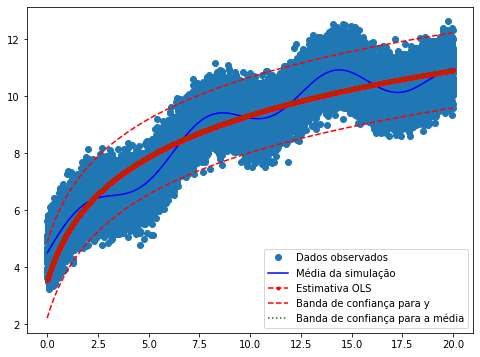

In [16]:
res = smf.ols('y ~ I(np.log(X1+1))',data=df).fit()

esp_vs_obs(data=df);

<AxesSubplot:xlabel='X1', ylabel='y'>

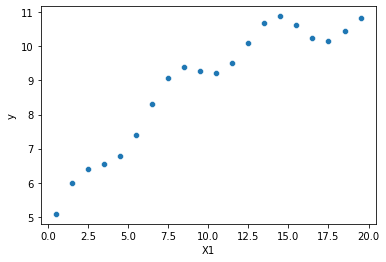

In [17]:
grupos = pd.qcut(df.X1, 20)

tab = df.groupby(grupos)['y'].describe()
tab['X1'] = df.groupby(grupos)['X1'].mean()
tab['y_true'] = df.groupby(grupos)['y_true'].mean()

tab.rename(columns={'mean':'y'}, inplace=True)

sns.scatterplot(data=tab, x = 'X1', y = 'y')

R-quadrado: 94.78%


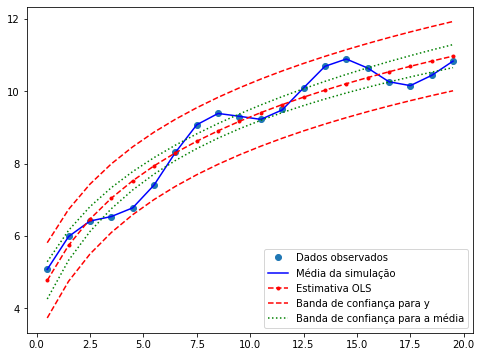

In [18]:
res = smf.ols('y ~ I(np.log(X1+2))',data=tab).fit()
print(f'R-quadrado: {res.rsquared:.2%}')
esp_vs_obs(data=tab);

In [19]:
df_train_b = df_train.merge(tab_perfil, on='tempo_emprego_cat', how='left')
df_train_b.head()

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,tempo_emprego_cat,log_renda,qtd_obs,log_renda_med,tempo_emprego_med
0,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14,"(15.214, 20.216]",9.318131,29999.0,10.657687,17.538365
1,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81,"(9.082, 10.436]",7.793508,30005.0,9.599298,9.741024
2,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66,"(8.107, 9.082]",9.528769,29740.0,9.428302,8.572256
3,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84,"(0.816, 1.458]",7.767196,30031.0,8.454323,1.125014
4,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78,"(0.816, 1.458]",6.673020,30031.0,8.454323,1.125014


In [20]:
X2 = patsy.dmatrices('''log_renda ~ 
                    + C(posse_de_imovel)
                    + qtd_filhos 
                    + idade
                    + tempo_emprego_cat 
                    + 1''', df_train_b)

res_2 = smf.ols(X2, data=df_train_b).fit()
print(f'R-quadrado ajustado: {res_2.rsquared_adj:.2%}')

R-quadrado ajustado: 42.02%


In [ ]:
lowess = sm.nonparametric.lowess(df_train_b.log_renda, df_train_b.tempo_emprego, frac=2/3)

In [ ]:
lowess_x = lowess[:, 0]
lowess_y = lowess[:, 1]

f = interp1d(lowess_x, lowess_y, bounds_error=False)

df_train_b['tempo_emprego_lowess'] = f(df_train_b.tempo_emprego)
df_train_b.head()

In [ ]:
X3 = patsy.dmatrices('''log_renda ~ 
                    + C(posse_de_imovel)
                    + qtd_filhos 
                    + idade
                    + tempo_emprego_lowess 
                    + 1''', df_train_b)

res_3 = smf.ols(X3, data=df_train_b).fit()
print(f'R-quadrado ajustado: {res_3.rsquared_adj:.2%}')

### Avaliando o modelo

Avalie os resultados dos modelos construidos na base de testes.

In [36]:
df_test['tempo_emprego_cat'] = pd.cut(df_test.tempo_emprego, bins = quebras, duplicates='drop')

warnings.filterwarnings('ignore')

In [37]:
df_test['tempo_emprego_cat'].isna().value_counts()

False    149991
True          9
Name: tempo_emprego_cat, dtype: int64

In [38]:
df_test.dropna(inplace=True)

In [40]:
df_test['pred_2'] = res_2.predict(df_test)

In [41]:
r = df_test[['pred_2', 'log_renda']].corr().iloc[0,1]
r**2

0.5247549560888964

##### Lowess

In [42]:
lowess = sm.nonparametric.lowess(df_test.log_renda, df_test.tempo_emprego, frac=2/3)

In [45]:
lowess_x = lowess[:, 0]
lowess_y = lowess[:, 1]

f = interp1d(lowess_x, lowess_y, bounds_error=False)

df_test['tempo_emprego_lowess'] = f(df_test.tempo_emprego)
df_test.head(2)

,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,log_renda,tempo_emprego_cat,pred_2,tempo_emprego_lowess
data_ref,,,,,,,,,,,,,,,,,
2016-01-01,12946,F,N,S,0,Pensionista,Médio,Casado,Casa,61,6.046575,2.0,2137.61,7.667444,"(5.759, 6.047]",9.091657,7.900725
2016-01-01,8872,F,N,S,2,Servidor público,Superior completo,Casado,Casa,27,9.301370,4.0,13884.35,9.538518,"(9.082, 10.436]",9.618868,8.342858


In [ ]:
df_test['pred_3'] = res_3.predict(df_test)

In [ ]:
r = df_test[['pred_3', 'log_renda']].corr().iloc[0,1]
r**2